# Histological Tissue patch  classification Data Mining  2

Training and Testing: Use data from the first two folds for training and validation and the third fold
for testing. Wherever applicable, performance metrics for the test fold (3
rd Fold) are two be reported
unless otherwise specified

Download the data

In [1]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


from skimage import data
from skimage.color import rgb2hed, hed2rgb
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from scipy.stats import entropy
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from skimage.measure import shannon_entropy
# pip install google.colab
from google.colab import drive 
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sys
%matplotlib inline

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics 
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold



In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Read the data

In [4]:
X = np.load('/content/gdrive/My Drive/images.npy')#read images 256x256x3(rgb)
Y = pd.read_csv('/content/gdrive/My Drive/counts.csv')#read cell counts nx6 where row is image patch and column is cell count T3: lymphocyte
F = np.loadtxt('/content/gdrive/My Drive/split.txt')#read fold information
np.set_printoptions(threshold=sys.maxsize)


In [5]:
# first_fold_cell_counts = Y[Y.index.isin(first_fold)]


# Question 1 Data Analysis

**i) How many examples are in each fold**

In [6]:
first_fold_shape = np.where(F==1)[0].shape
second_fold_shape = np.where(F==2)[0].shape
third_fold_shape = np.where(F==3)[0].shape

print("First fold contains :",first_fold_shape, "examples")
print("Second fold contains :",second_fold_shape,"examples")
print("Third fold contains :",third_fold_shape,"examples")


First fold contains : (1622,) examples
Second fold contains : (1751,) examples
Third fold contains : (1608,) examples


**ii) Show some image examples using plt.imshow. Describe your observations on what you
see in the images and how it correlates with the cell counts of different types of cells
especially T3 cells.** Cells : T1:
neutrophil , T2: epithelial T3: lymphocyte, T4: plasma , T5: eosinophil and T6: connective)

In [7]:
#Find images with highest and lowest count of T3:

t3_high = Y['lymphocyte'].nlargest(n = 10)
t3_low = Y['lymphocyte'].nsmallest(n = 10)          
          
print(Y['lymphocyte'].nlargest(n = 10))
print(Y['lymphocyte'].nsmallest(n = 10))

308     450
303     391
1544    320
3375    309
4933    293
4936    281
302     278
4212    264
4205    257
4934    257
Name: lymphocyte, dtype: int64
0     0
3     0
23    0
54    0
55    0
61    0
64    0
66    0
67    0
68    0
Name: lymphocyte, dtype: int64


In [8]:
t3_high.index

Int64Index([308, 303, 1544, 3375, 4933, 4936, 302, 4212, 4205, 4934], dtype='int64')

In [9]:
t3_low.index

Int64Index([0, 3, 23, 54, 55, 61, 64, 66, 67, 68], dtype='int64')

##Visualise 10 highest and 10 lowest concentrations of T3 to tell the differences :

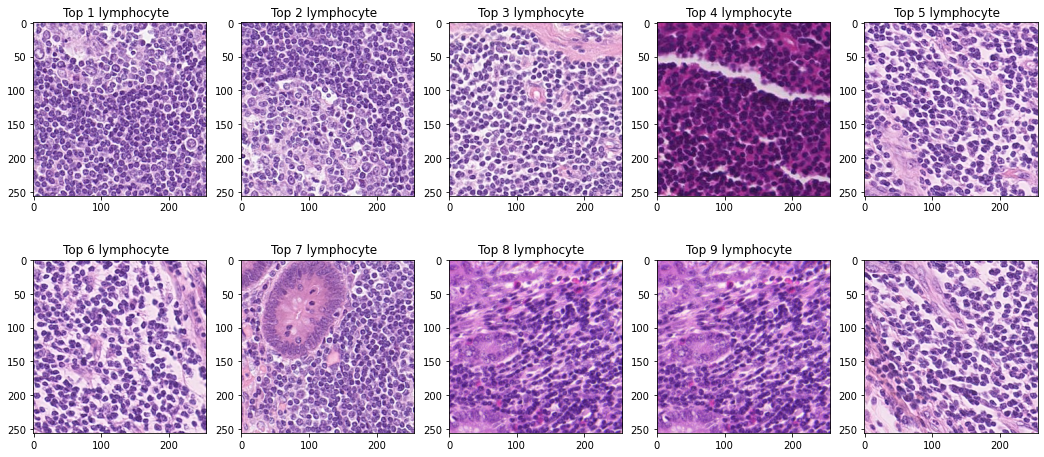

In [10]:
#plot the 10 examples with the highest T3  using imshow
h = 0
j=1
plt.figure(figsize = (18,8))
for i in t3_high.index:
    plt.title("Top "+str(h)+ " lymphocyte  ")
    plt.subplot(2,5,j)
    plt.imshow(X[i])
    j += 1
    h +=1
    

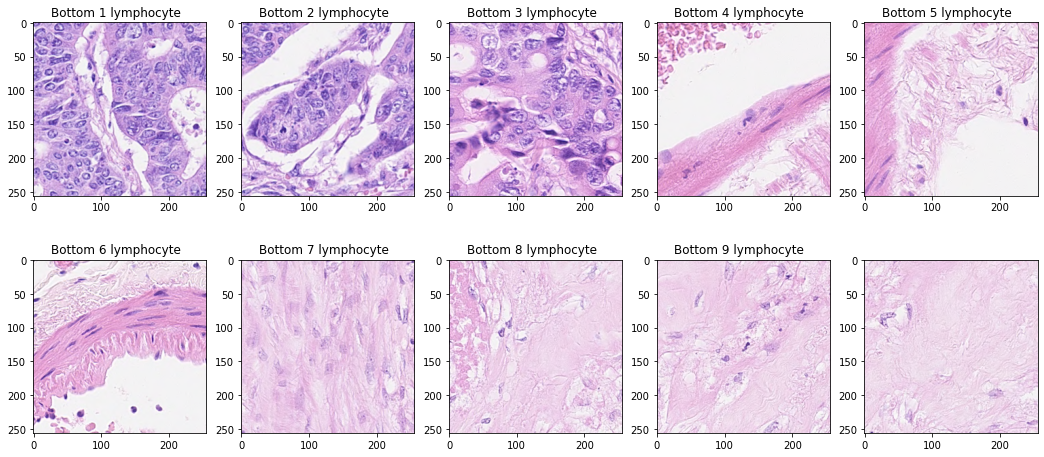

In [11]:
#plot the 10 examples with the lowest T3 and lowest T3 using imshow

h = 0
j=1
plt.figure(figsize = (18,8))
for i in t3_low.index:
    plt.title("Bottom "+str(h)+ " lymphocyte  ")
    plt.subplot(2,5,j)
    plt.imshow(X[i])
    j += 1
    h +=1


# Comment on T3 cell appereance on images

As it can be observed from the top and bottom 10 lymphocyte concentration images, that the histology images high high T3 counts display a lot of round dense dark cells of similar diameters and characteristics.On the other hand the images with lower T3 counts appear to have lighter components in terms of color that are not that clearly shaped.

**iii) For each fold, plot the histogram of counts of each cell type separately (6 plots in total). How
many images have counts within each of the following bins?**



We will filter our original dataframe Y to include only the index of the images in all folds we got ***(Fayaz said its alright instead of plotting 18 plots we can plot 6) ***

In [12]:
first_fold =  np.where(F==1)[0]

In [13]:
#create

first_fold_cell_counts = Y[Y.index.isin(first_fold)]
first_fold_cell_counts

,neutrophil,epithelial,lymphocyte,plasma,eosinophil,connective
136,0,54,4,7,0,12
137,0,95,2,4,0,5
138,0,101,14,13,3,25
139,0,14,7,3,1,34
140,0,0,0,0,0,2
...,...,...,...,...,...,...
4840,1,83,23,16,0,13
4841,0,53,29,28,4,31
4842,0,6,17,7,2,56
4843,0,53,28,23,3,33


In [14]:
counts = first_fold_cell_counts["neutrophil"]

In [15]:
counts

136     0
137     0
138     0
139     0
140     0
       ..
4840    1
4841    0
4842    0
4843    0
4844    0
Name: neutrophil, Length: 1622, dtype: int64

We need to make histograms based on the bins provided on the question

In [16]:
bin_values = [0, 1, 6, 11, 21, 31, 41, 51, np.inf]
labels = ('0','1-5','6-10','11-20','21-30','31-40','41-50','>50') #define feature names
groups = pd.cut(counts, bins = bin_values, labels = labels, right = False) #use panda.cut to group the data


bin_groups = groups.value_counts().sort_index()  #calculate the counts of each bin and sort the display by index
print(f'Counts  Neutrophil on each bin: \n {bin_groups}')


Counts  Neutrophil on each bin: 
 0        1308
1-5       235
6-10       40
11-20      28
21-30       7
31-40       3
41-50       1
>50         0
Name: neutrophil, dtype: int64


***Plot Histogram of Neutrophils of first fold***

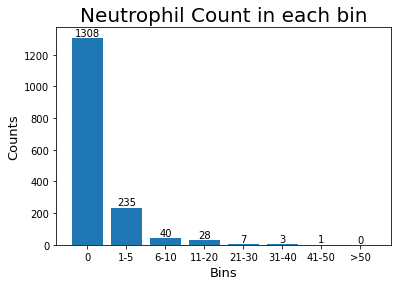

In [17]:
#note they should add up 1622 use this as a sanity check cause first fold is 1622
label_bins = ['0','1-5','6-10','11-20','21-30','31-40','41-50','>50']

#we use positions to coordinate which person goes where on the x-axis and where the labels go
positions  = [0,1,2,3,4,5,6,7]

counts = bin_groups


plt.bar(positions, counts, width=0.8, align="center")

plt.xticks(positions, label_bins)
for i in range(len(counts)):
    plt.text(i,counts[i], counts[i], ha = 'center',va = 'bottom')
plt.title('Neutrophil Count in each bin',fontsize=20)
plt.xlabel('Bins',fontsize=13)
plt.ylabel('Counts',fontsize=13)
plt.show()

**Find a way to do this for all 6 graphs (2 for loops)**

In [18]:
#make a for loop to do this faster:

bin_sizes = [(0,0), (1,5),(6,10),(11,20),(21,30),(31,40),(41,50),(51,np.inf)]
tissue_types = ['neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective']

for tissue in tissue_types:
    print('\n')
    print(tissue)
    for bin_specific in bin_sizes:
        print('Bin sizes {}, no of images {}'.format(bin_specific,len(Y[np.logical_and(Y[tissue]>=bin_specific[0],Y[tissue]<=bin_specific[1])])))
    
    
    
    
    
    
    
    
    



neutrophil
Bin sizes (0, 0), no of images 3912
Bin sizes (1, 5), no of images 867
Bin sizes (6, 10), no of images 121
Bin sizes (11, 20), no of images 64
Bin sizes (21, 30), no of images 10
Bin sizes (31, 40), no of images 3
Bin sizes (41, 50), no of images 4
Bin sizes (51, inf), no of images 0


epithelial
Bin sizes (0, 0), no of images 792
Bin sizes (1, 5), no of images 154
Bin sizes (6, 10), no of images 145
Bin sizes (11, 20), no of images 336
Bin sizes (21, 30), no of images 435
Bin sizes (31, 40), no of images 546
Bin sizes (41, 50), no of images 569
Bin sizes (51, inf), no of images 2004


lymphocyte
Bin sizes (0, 0), no of images 625
Bin sizes (1, 5), no of images 1365
Bin sizes (6, 10), no of images 652
Bin sizes (11, 20), no of images 888
Bin sizes (21, 30), no of images 556
Bin sizes (31, 40), no of images 312
Bin sizes (41, 50), no of images 184
Bin sizes (51, inf), no of images 399


plasma
Bin sizes (0, 0), no of images 1878
Bin sizes (1, 5), no of images 1639
Bin sizes

***Histograms with bins sizes for all cell types for FIRST fold (fayaz said we can do for 1 fold only)***

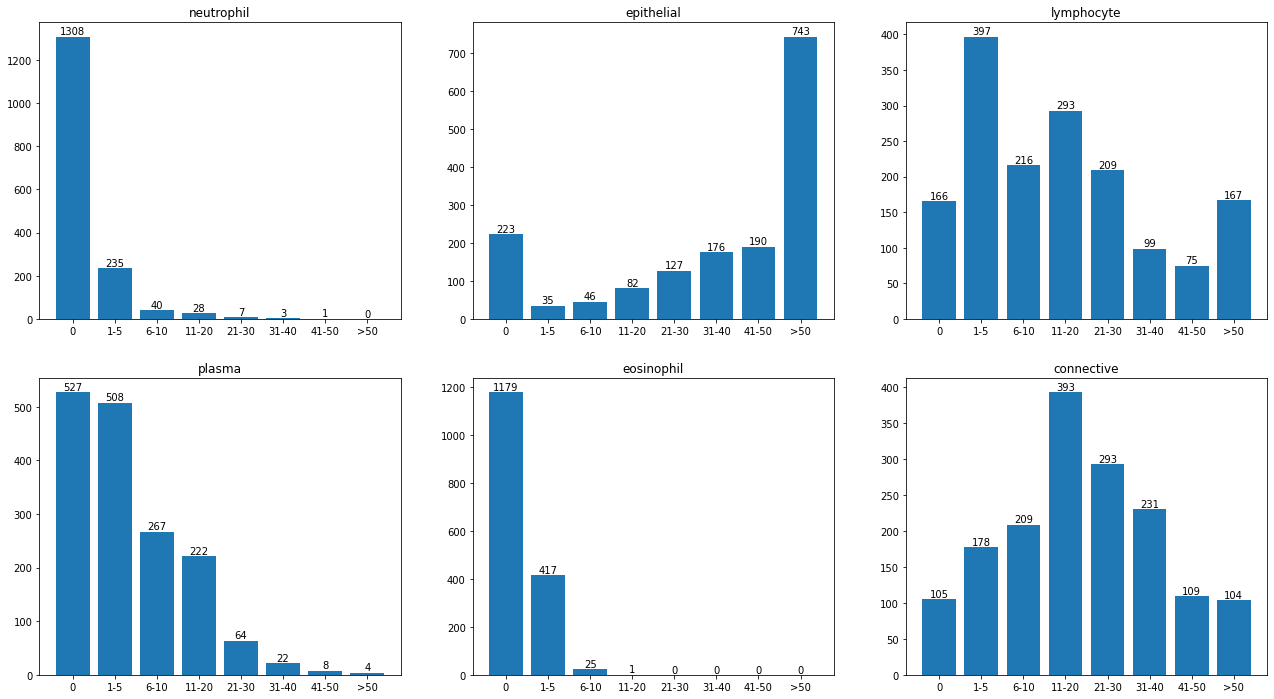

In [19]:
#for loop to plot the above 

j = 1
plt.figure(figsize= (22,12))
for tissue in tissue_types:
    count = []
    for bin_specific in bin_sizes:
        
        plots=len(first_fold_cell_counts[np.logical_and(first_fold_cell_counts[tissue]>=bin_specific[0],first_fold_cell_counts[tissue]<=bin_specific[1])])
        

        horizontal_bins = ['0','1-5','6-10','11-20','21-30','31-40','41-50','>50']
        positions  = [0,1,2,3,4,5,6,7]
        count.append(plots)


    plt.subplot(2,3,j)
    plt.title(tissue)
    plt.bar(positions, count, width=0.8, align="center")
    plt.xticks(positions, horizontal_bins)

    for k in range(len(counts)):
        plt.text(k,count[k], count[k], ha = 'center',va = 'bottom')
    
    j+=1        
        

***iv)*** Pre-processing: Convert and show a few images from RGB space to HED space and show the
H-channel which should indicate cellular nuclei.

In [20]:
ihc_rgb = X

<Figure size 720x720 with 0 Axes>

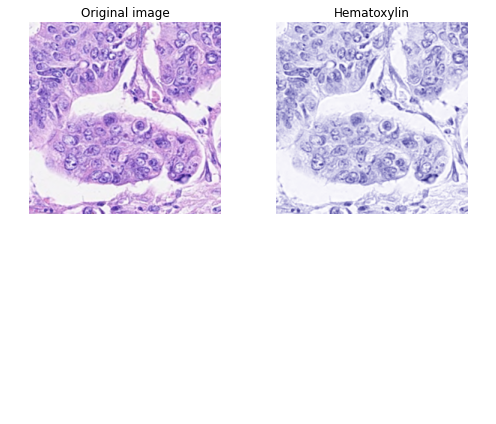

<Figure size 720x720 with 0 Axes>

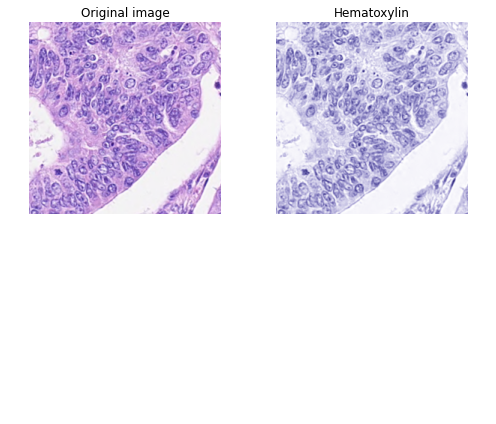

<Figure size 720x720 with 0 Axes>

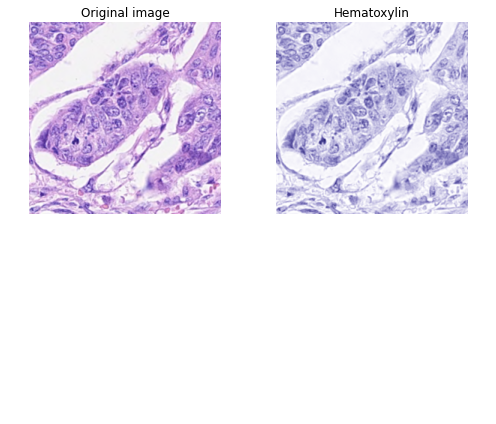

In [21]:
# Separate the stains from the IHC image and show some images from the H (hematoxylin) channel


for i in range(1,4):
    ihc_rgb = X[i]
    ihc_hed = rgb2hed(ihc_rgb)
    
    fig = plt.figure()
    fig.set_size_inches(w=10,h=10)
    
    # Separate the stains from the IHC image

# Create an RGB image for each of the stains
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))


    # Display
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(ihc_rgb)
    ax[0].set_title("Original image")

    ax[1].imshow(ihc_h)
    ax[1].set_title("Hematoxylin")



    for a in ax.ravel():
        a.axis('off')

    fig.tight_layout()

**it is visible that the h-channel images highlight the cellular nuclei in darker blue, those are the T3 cells in the original image counts**



**v)** Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain
type for images in Fold-1 (6 plots in total). Do you think this feature would be useful in your
regression model? Explain your reasoning.

In [22]:
#get Average of h-channel for each image and append in a list

h_channel_avg = []


X_fold_1 = X[F==1]
Y_fold_1 = Y[F==1]


for i in range(len(X_fold_1)):
    
    ihc_hed = rgb2hed(X_fold_1[i])
    ihc_hehe = ihc_hed[:,:,0] 
    #create empty matrix of the h channel 

    #append average h channel values in empty list created
    h_channel_avg.append(np.mean(ihc_hehe))
    


**IF YOU RERUN THE CODE PLEASE RUN THE BELOW CELL 2 TIMES TO RESCALE THE PLOTS TO READABLE SIZE**

Text(0.5, 1.0, 'H-Channel Average vs Connective Count ')

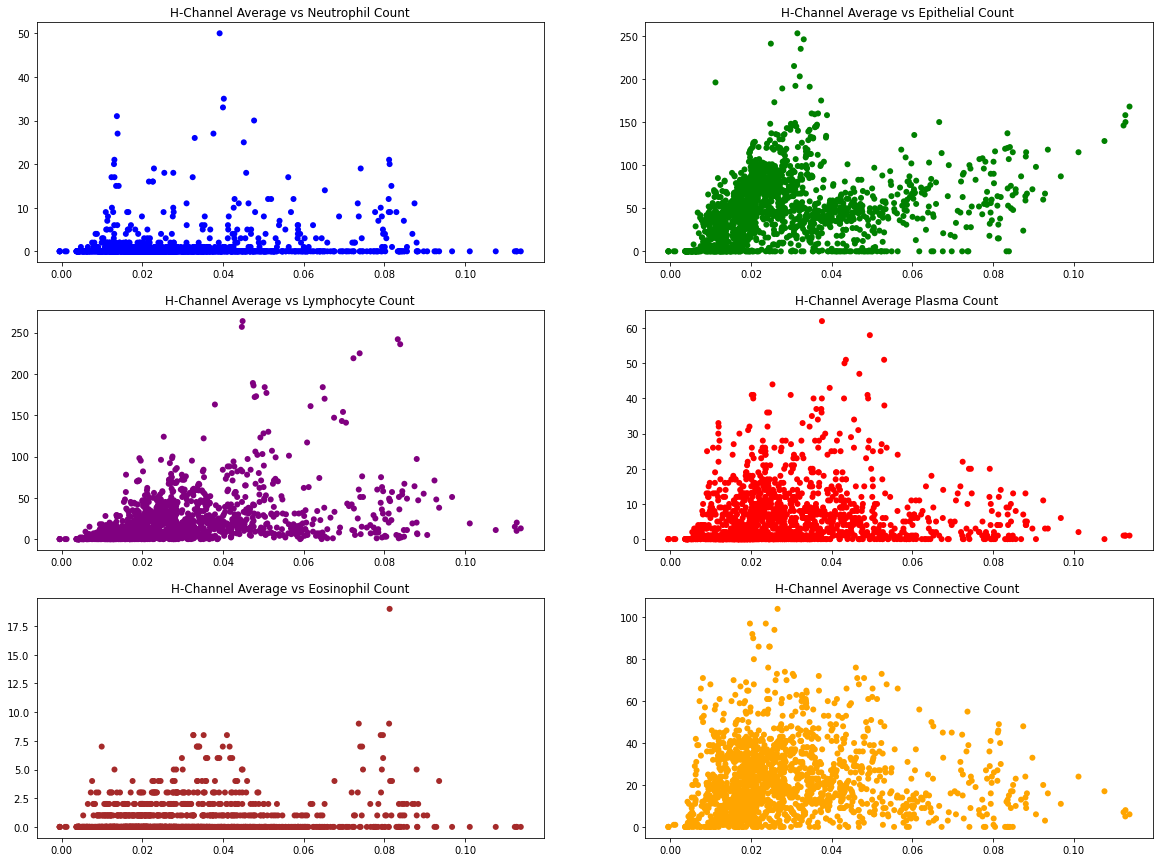

In [74]:
#visualise scatter plots of the average h channel values we got vs all types of cell counts
fig, axes = plt.subplots(3, 2)
ax = axes.ravel()
plt.rcParams['figure.figsize'] = [15, 15]

ax[0].scatter(h_channel_avg,np.array(Y_fold_1['neutrophil']), color = 'blue', edgecolor='none')
ax[0].set_title("H-Channel Average vs Neutrophil Count")

ax[1].scatter(h_channel_avg,np.array(Y_fold_1['epithelial']), color = 'green', edgecolor='none')
ax[1].set_title("H-Channel Average vs Epithelial Count ")

ax[2].scatter(h_channel_avg,np.array(Y_fold_1['lymphocyte']), color = 'purple', edgecolor='none')
ax[2].set_title("H-Channel Average vs Lymphocyte Count")

ax[3].scatter(h_channel_avg,np.array(Y_fold_1['plasma']), color = 'red', edgecolor='none')
ax[3].set_title("H-Channel Average Plasma Count ")

ax[4].scatter(h_channel_avg,np.array(Y_fold_1['eosinophil']), color = 'brown', edgecolor='none')
ax[4].set_title("H-Channel Average vs Eosinophil Count")

ax[5].scatter(h_channel_avg, np.array(Y_fold_1['connective']), color = 'orange', edgecolor='none')
ax[5].set_title("H-Channel Average vs Connective Count ")





**The above scatter plots do not indicate a strong relationship between different cell counts and h_channel average values. This means that this feature will probably not provide a lot of information when running the regression model or the CNN. One thing that can be observed is that Eosinophil counts seem to have discreet values as they seem to have limited values that can be taken. Epithelial, Lymphocyte, Plasma and Connective tend to have a very weak positive linear relationship or no relationship at all.Lymphocyte,Epithelial, Plasma and Connective scatter plots display a moderately weak positive linear relationship.This means that the h-channel features might not be valuable indicators in establishing models that will display high predictive power**

**vi)**. What performance metrics can you use for this problem? Which one will be the best
performance metric for this problem? Please give reasoning.

For the purposes of this multiclass regression problem we can use **RMSE, R-squared and correlation coefficient.**


**R-squared** or else known as goodness of fit will let us know how well our model explains the percentage of variance of the independent variable that the dependent variables explain collectively. R-squared can be used to signify how well our model can predict cellular composition. The closer it will be to 1 the more variance of the dependent varible will be explained by the independent variables.

**RMSE** indicated the standart deviation of the prediction errors i.e how far from the regression line the data points are. It is a measure of spread of the points around the line of best fit. The lower the RMSE the better our model will predict the cellular composition.


**For selection of features :**We can use **corellation coefficient** to see how the dependent variable of cell type is associated with the independent variables and whether they have a positive or negative relationship.We can use this metric to select the important features to use for our regression.


Note that for all the above it is important to train the regression model on training data, but test on unseen data to make sure the model generalises well and does not overfit.

# Question No. 2: (Feature Extraction and Classical Regression) 

For the following questions, use only T3 type of cells as the output prediction variable.

**i). Extract features from a given image. Specifically, calculate the:**
a. average of the “H”, red, green and blue channels
b. variance of the “H”, red, green and blue channels
c. entropy of the “H”, red, green and blue channels
d. Any other features that you think can be useful for this work. Describe your
reasoning for using these features. 

**a)**

In [24]:
#this takes 1 minute!
pictures_hed = rgb2hed(X)


In [25]:
#for loop for red channel metrics

red_channel_avg=[]
red_channel_var=[]
red_channel_entropy=[]

for i in range(len(X)):
    red_channel_avg.append(np.mean(X[i][:,:,0]))
    red_channel_var.append(np.var(X[i][:,:,0]))
    red_channel_entropy.append(shannon_entropy(X[i][:,:,0]))

        

In [26]:
#for loop for green channel metrics
green_channel_avg = []
green_channel_var = []
green_channel_entropy = []

for i in range(len(X)):
    green_channel_avg.append(np.mean(X[i][:,:,1]))
    green_channel_var.append(np.var(X[i][:,:,1]))
    green_channel_entropy.append(shannon_entropy(X[i][:,:,1]))


In [27]:
#for loop for blue channel metrics :
blue_channel_avg = []
blue_channel_var = []
blue_channel_entropy = []

for i in range(len(X)):
    blue_channel_avg.append(np.mean(X[i][:,:,2]))
    blue_channel_var.append(np.var(X[i][:,:,2]))
    blue_channel_entropy.append(shannon_entropy(X[i][:,:,2]))


In [28]:
#for loop for h-channel metrics NB! we have to find those metrics on the hed converted images this takes 2 minutes to run!
h_channel_avg_1 = []
h_channel_var = []
h_channel_entropy = []

for i in range(len(X)):
    h_channel_avg_1.append(np.mean(pictures_hed[i][:,:,0]))
    h_channel_var.append(np.var(pictures_hed[i][:,:,0]))
    h_channel_entropy.append(shannon_entropy(pictures_hed[i][:,:,0]))



In [29]:
#now append the 12 variables of size 4981 in a dataframe to plot them and  also get extra components
variables_list = [h_channel_avg_1,h_channel_var,h_channel_entropy,red_channel_avg,
                  red_channel_var,red_channel_entropy,
             green_channel_avg,green_channel_var,green_channel_entropy,
             blue_channel_avg,blue_channel_var,blue_channel_entropy,Y['lymphocyte']]
dataframe = pd.DataFrame(variables_list)
dataframe = dataframe.transpose()

dataframe.columns= ['h_channel_avg','h_channel_var','h_channel_entropy','red_channel_avg','red_channel_var',
           'red_channel_entropy',
             'green_channel_avg','green_channel_var','green_channel_entropy',
             'blue_channel_avg','blue_channel_var','blue_channel_entropy','Lymphocyte']
    
    
    

In [30]:
dataframe

,h_channel_avg,h_channel_var,h_channel_entropy,red_channel_avg,red_channel_var,red_channel_entropy,green_channel_avg,green_channel_var,green_channel_entropy,blue_channel_avg,blue_channel_var,blue_channel_entropy,Lymphocyte
0,0.028605,0.000512,15.118937,197.698242,1331.335242,7.063311,170.029984,1876.016023,7.343395,220.461472,481.998760,6.344929,0.0
1,0.026076,0.000533,14.800732,202.473419,1417.460078,6.976390,176.373886,2178.975367,7.268564,222.857880,509.681401,6.295099,1.0
2,0.029113,0.000586,14.575099,197.348557,1539.463942,6.973113,170.161255,2307.646238,7.158988,220.063202,535.724338,6.306477,3.0
3,0.023963,0.000505,14.493204,205.994827,1436.195576,6.846146,180.647141,2438.515856,7.157774,223.980301,513.623590,6.219650,0.0
4,0.033358,0.000476,15.173962,188.374313,1233.496379,7.107354,154.436249,1642.879389,7.331547,214.194946,537.033895,6.480956,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,0.017122,0.000275,14.971538,212.572479,964.245205,6.744447,172.512909,1629.919114,7.253116,217.049973,580.884420,6.481390,17.0
4977,0.020583,0.000568,14.522170,206.418716,1766.249466,6.802577,165.679520,3407.630187,7.270968,209.284439,1057.736126,6.618228,9.0
4978,0.023932,0.000645,14.114807,202.140808,2090.342844,6.758527,166.652145,4087.511367,7.132989,209.097931,1211.674858,6.540363,1.0
4979,0.023750,0.000663,14.124510,202.249878,2105.959045,6.750199,164.874191,4008.991847,7.182015,208.633499,1247.109223,6.550184,8.0


#  Extract new features and Flatten data for PCA


I chose to add three extra features mainly the reduced components of the red ,green and blue channels. I initially wanted to perform PCA on the whole dataset but this was not deemed possible due to computational constraints

In [31]:
#we now need to create conditions for the PCA analysis to happen we need to take the 3 channels first 

red_channel_pca = X[:,:,0]
green_channel_pca = X[:,:,1]
blue_channel_pca = X[:,:,2]
h_channel_pca = pictures_hed[:,:,0]

In [32]:
# Standardise channels by dividing by 255 if i do it with the package it crashes for some reason? maybe computational power?

red_channel_pca = red_channel_pca/255

green_channel_pca = green_channel_pca/255

blue_channel_pca = blue_channel_pca/255

entire_data_standartdised = X/255




In [33]:
from numpy.ma.core import append
#flatten images to be able to pass it on standardiser create 3 empty lists and append

flattened_red = []

for i in range(len(X)):
  #get red channel 0
  flattened_red.append(red_channel_pca[i].flatten())

flattened_green = []
for i in range(len(X)):
  #get green channel 1
  flattened_green.append(green_channel_pca[i].flatten())

flattened_blue = []
for i in range(len(X)):
  #get blue channel 2
  flattened_blue.append(blue_channel_pca[i].flatten())






In [34]:
#fit pca for rgb channels and add to the df for correlation analysis

pca = PCA(n_components = 1).fit(flattened_red)

pca_red = pca.transform(flattened_red)

pca_green = pca.transform(flattened_green)

pca_blue = pca.transform(flattened_blue)



In [35]:
dataframe['pca_red'] = pca_red
dataframe['pca_green'] = pca_green
dataframe['pca_blue'] = pca_blue

In [36]:
correlations = dataframe.corr()

correlations

,h_channel_avg,h_channel_var,h_channel_entropy,red_channel_avg,red_channel_var,red_channel_entropy,green_channel_avg,green_channel_var,green_channel_entropy,blue_channel_avg,blue_channel_var,blue_channel_entropy,Lymphocyte,pca_red,pca_green,pca_blue
h_channel_avg,1.000000,0.855478,0.153148,-0.978382,0.648462,0.545942,-0.813032,0.253182,0.280576,-0.886207,0.497683,0.485958,0.330425,0.830264,0.830770,0.830574
h_channel_var,0.855478,1.000000,0.157465,-0.852368,0.899910,0.547259,-0.741253,0.517468,0.312592,-0.815825,0.762523,0.511239,0.439914,0.752722,0.753038,0.752370
h_channel_entropy,0.153148,0.157465,1.000000,-0.238377,0.276711,0.861772,-0.404417,0.223665,0.947218,-0.272979,0.193171,0.878545,0.207263,0.309479,0.310223,0.311082
red_channel_avg,-0.978382,-0.852368,-0.238377,1.000000,-0.680875,-0.631951,0.907137,-0.279117,-0.353031,0.954122,-0.516764,-0.566352,-0.360468,-0.897818,-0.898222,-0.898079
red_channel_var,0.648462,0.899910,0.276711,-0.680875,1.000000,0.618596,-0.646915,0.782903,0.458207,-0.673728,0.891889,0.601329,0.401639,0.638202,0.638910,0.638326
red_channel_entropy,0.545942,0.547259,0.861772,-0.631951,0.618596,1.000000,-0.711482,0.427278,0.929268,-0.640126,0.469041,0.976618,0.320366,0.640178,0.641067,0.641486
green_channel_avg,-0.813032,-0.741253,-0.404417,0.907137,-0.646915,-0.711482,1.000000,-0.301027,-0.460908,0.961471,-0.471891,-0.652299,-0.385670,-0.923851,-0.924180,-0.924436
green_channel_var,0.253182,0.517468,0.223665,-0.279117,0.782903,0.427278,-0.301027,1.000000,0.430743,-0.287446,0.796471,0.467360,0.128848,0.292297,0.292940,0.292637
green_channel_entropy,0.280576,0.312592,0.947218,-0.353031,0.458207,0.929268,-0.460908,0.430743,1.000000,-0.365088,0.376904,0.955242,0.215746,0.390814,0.391663,0.392154
blue_channel_avg,-0.886207,-0.815825,-0.272979,0.954122,-0.673728,-0.640126,0.961471,-0.287446,-0.365088,1.000000,-0.545889,-0.596258,-0.375746,-0.924329,-0.924358,-0.924080


##Extra Feature : Connected Components :

**What are connected components? Basically, it allows us to detect objects with irregular shapes and sizes based on the pixels’ connectivity to their neighbors in an image.This will be extremely useful as an additional feature in theory as it will "segment" the regions of the histological images depending on different pixel intensities. Regions with very high counts of specific cells will display very different connected component values that regions with different cells. This extra feature will be added by first converting the images to gray scale and applying a thresholding rule (for this instance 0.55) was selected but this is subject upon change depending on the histological images. I am aware that techniques like GLOB or even histogram intensity based metrics could also work well as additional features to add in the feature set. One drawback however of, the use of connected components operations heavily relies on adequately cleaning the image using morphological operation.**

In [37]:
from cv2 import *
from skimage.color.colorconv import rgb2gray
#to get this extra feature that will tell us about the textural nature of the image and improve our performance we can use connected components. In order to do this we need to convert images to grayscale and threshold

convert_images_to_grayscale = []

for imgs in range(len(X)):
  grayscale_images = rgb2gray(X[imgs])
  convert_images_to_grayscale.append(grayscale_images)
threshold = 0.55

In [38]:
for imgs in range(len(convert_images_to_grayscale)):
  convert_images_to_grayscale[imgs][convert_images_to_grayscale[imgs]>threshold] = 1
  convert_images_to_grayscale[imgs][convert_images_to_grayscale[imgs]<threshold] = 0




In [39]:
connectivity = 8
connected_labels=[]
for value in range(len(convert_images_to_grayscale)):
  con_lab, labels, stats, centroids = cv2.connectedComponentsWithStats(convert_images_to_grayscale[value].astype(np.uint8) , connectivity , cv2.CV_32S)
  connected_labels.append(con_lab)

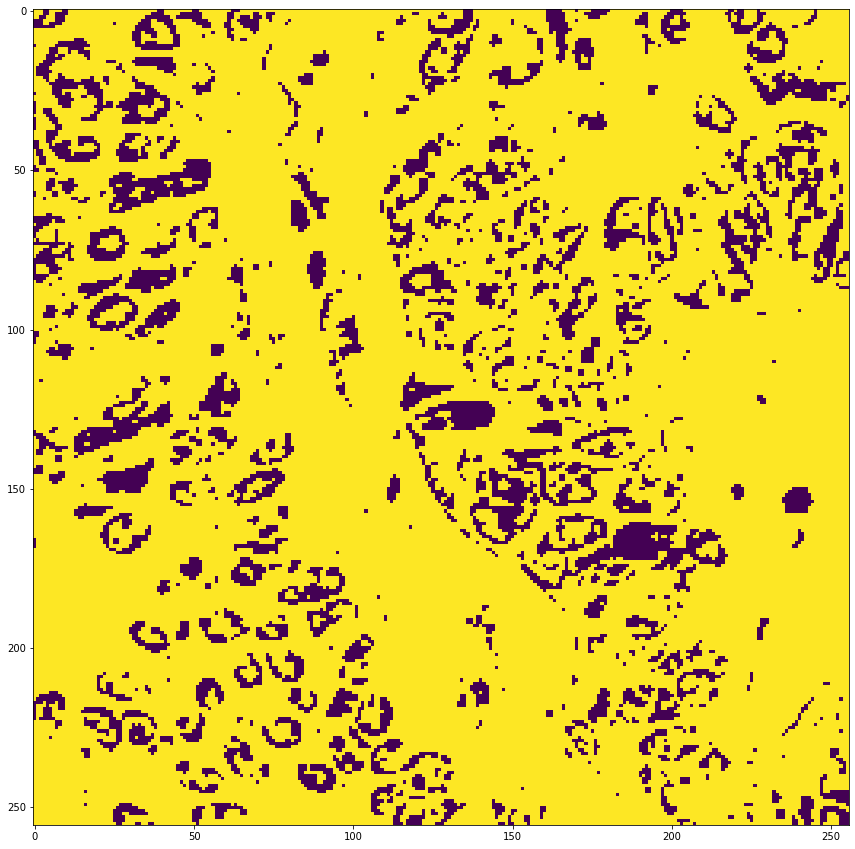

In [40]:
#display a connected component mask to make sure it was done correctly

from pylab import *



imshow(convert_images_to_grayscale[0])

In [41]:
dataframe['connected_components'] = connected_labels


In [42]:
#put the list back on the dataframe :

dataframe

,h_channel_avg,h_channel_var,h_channel_entropy,red_channel_avg,red_channel_var,red_channel_entropy,green_channel_avg,green_channel_var,green_channel_entropy,blue_channel_avg,blue_channel_var,blue_channel_entropy,Lymphocyte,pca_red,pca_green,pca_blue,connected_components
0,0.028605,0.000512,15.118937,197.698242,1331.335242,7.063311,170.029984,1876.016023,7.343395,220.461472,481.998760,6.344929,0.0,-0.848605,-0.960986,-1.038697,44
1,0.026076,0.000533,14.800732,202.473419,1417.460078,6.976390,176.373886,2178.975367,7.268564,222.857880,509.681401,6.295099,1.0,-2.721977,-2.539269,-2.065670,50
2,0.029113,0.000586,14.575099,197.348557,1539.463942,6.973113,170.161255,2307.646238,7.158988,220.063202,535.724338,6.306477,3.0,-2.369889,-2.565062,-2.669861,88
3,0.023963,0.000505,14.493204,205.994827,1436.195576,6.846146,180.647141,2438.515856,7.157774,223.980301,513.623590,6.219650,0.0,-2.303721,-2.310893,-2.377545,57
4,0.033358,0.000476,15.173962,188.374313,1233.496379,7.107354,154.436249,1642.879389,7.331547,214.194946,537.033895,6.480956,7.0,-0.841065,-1.484085,-1.707769,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,0.017122,0.000275,14.971538,212.572479,964.245205,6.744447,172.512909,1629.919114,7.253116,217.049973,580.884420,6.481390,17.0,-1.728117,-1.506875,-1.573770,38
4977,0.020583,0.000568,14.522170,206.418716,1766.249466,6.802577,165.679520,3407.630187,7.270968,209.284439,1057.736126,6.618228,9.0,-1.572824,-1.798610,-1.896393,170
4978,0.023932,0.000645,14.114807,202.140808,2090.342844,6.758527,166.652145,4087.511367,7.132989,209.097931,1211.674858,6.540363,1.0,-0.813927,-0.708549,-0.525887,242
4979,0.023750,0.000663,14.124510,202.249878,2105.959045,6.750199,164.874191,4008.991847,7.182015,208.633499,1247.109223,6.550184,8.0,-0.946767,-0.896115,-0.858556,272


##Get Correlations of lymphocyte cell counts with other variables

Below we can have a ranking of the correlations of all the feature set including the additional features we generated with T3 cells. As we can observe most features display weak correlation either negative or positive with T3 cells.It is a positive sign however that the generated features coming from the PCA of the r,g,b channels as well as the connected components variable rank among the first 7 strongest correlations, this will definitely improve perfomance. 

In [43]:
cor= dataframe.corr()

cor_unstacked = cor.unstack()

corr_df = pd.DataFrame(cor_unstacked['Lymphocyte'],columns=['Pearson coef'])


corr_df = corr_df.sort_values(by='Pearson coef',ascending=False)


In [44]:
corr_df

,Pearson coef
Lymphocyte,1.000000
h_channel_var,0.439914
red_channel_var,0.401639
connected_components,0.366718
pca_green,0.354959
pca_blue,0.354769
pca_red,0.354083
h_channel_avg,0.330425
red_channel_entropy,0.320366
blue_channel_entropy,0.287921


## **Which features do you think are important? Justify your reasoning**

In order to dentify the feature set which is most relevant to the dependent variable we can use correlation coefficient as a metric.Especially for cases when there are numerical input variables and a numerical target for regression predictive modeling. Under this settings we can use **Correlation Coefficient and Mutual Information Statistics**. 

Correlation coefficient will explain the linear relationship between 2 variables and assume a gaussian distribution for linear regression. The values it can take will range from [-1,1]. 

The greater the relationship of two variables (positive or negative) **the more likely for the one variable to be a good estimator in explaining the other variable**. For the above reason we will consider all the variables with correlations >0.35 (weak correlations) to be important. These features include the new features we **engineered like Connected components and PCA of r,g,b channels.** So we will have a list of important variables which will **include:** 

[h_channel_var,red_channel_var,connected_components,pca_green,pca_blue,pca_red,blue_channel_avg,green_channel_avg,red_channel_avg].

## Visualise correlogram heatmap

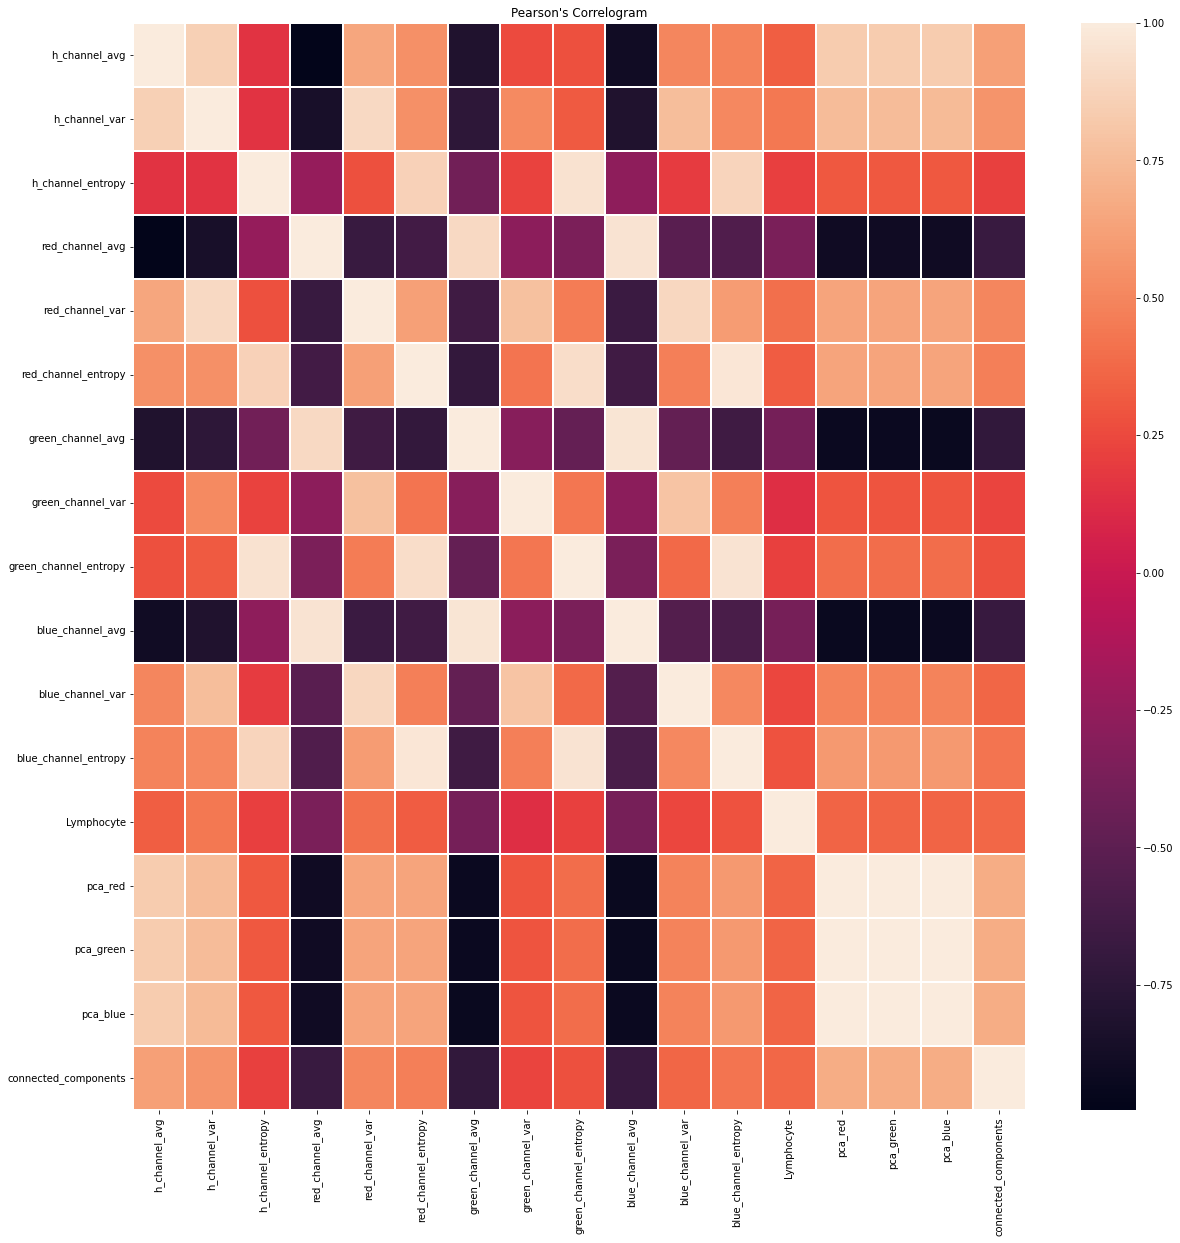

In [45]:
#plot, leaving default method is pearsons
plt.figure(figsize = [20,20])
plt.title("Pearson's Correlogram")

sns.heatmap(cor,linewidths=1)



##Scatter plots of average,variance and entropy of the “H”, red, green and blue channel  vs T3 target variable counts

Text(0.5, 1.0, 'Blue channel entropy vs  Lymphocyte Count ')

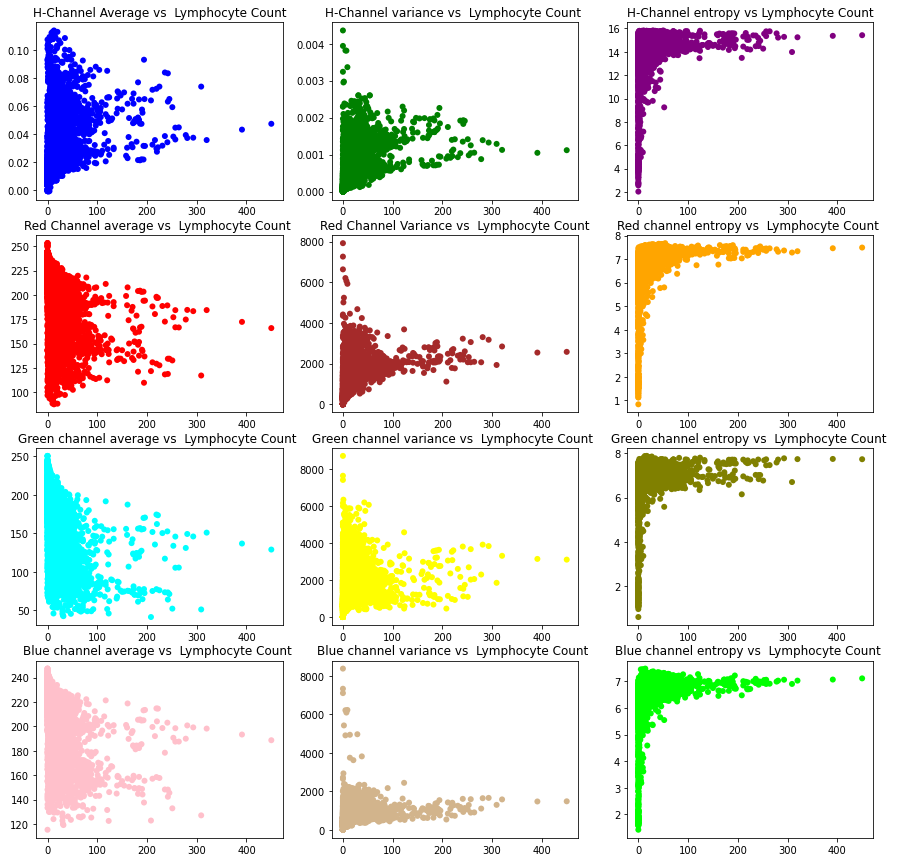

In [46]:
fig, axes = plt.subplots(4, 3)
ax = axes.ravel()
plt.rcParams['figure.figsize'] = [20, 15]


ax[0].scatter(dataframe['Lymphocyte'],h_channel_avg_1, color = 'blue', edgecolor='none')
ax[0].set_title("H-Channel Average vs  Lymphocyte Count")

ax[1].scatter(dataframe['Lymphocyte'],h_channel_var, color = 'green', edgecolor='none')
ax[1].set_title("H-Channel variance vs  Lymphocyte Count ")

ax[2].scatter(dataframe['Lymphocyte'],h_channel_entropy, color = 'purple', edgecolor='none')
ax[2].set_title("H-Channel entropy vs Lymphocyte Count")

ax[3].scatter(dataframe['Lymphocyte'],red_channel_avg, color = 'red', edgecolor='none')
ax[3].set_title("Red Channel average vs  Lymphocyte Count ")

ax[4].scatter(dataframe['Lymphocyte'],red_channel_var, color = 'brown', edgecolor='none')
ax[4].set_title("Red Channel Variance vs  Lymphocyte Count")

ax[5].scatter(dataframe['Lymphocyte'],red_channel_entropy, color = 'orange', edgecolor='none')
ax[5].set_title("Red channel entropy vs  Lymphocyte Count ")

ax[6].scatter(dataframe['Lymphocyte'],green_channel_avg, color = 'cyan', edgecolor='none')
ax[6].set_title("Green channel average vs  Lymphocyte Count ")

ax[7].scatter(dataframe['Lymphocyte'],green_channel_var, color = 'yellow', edgecolor='none')
ax[7].set_title("Green channel variance vs  Lymphocyte Count ")

ax[8].scatter(dataframe['Lymphocyte'],green_channel_entropy, color = 'olive', edgecolor='none')
ax[8].set_title("Green channel entropy vs  Lymphocyte Count ")

ax[9].scatter(dataframe['Lymphocyte'],blue_channel_avg, color = 'pink', edgecolor='none')
ax[9].set_title("Blue channel average vs  Lymphocyte Count ")

ax[10].scatter(dataframe['Lymphocyte'],blue_channel_var, color = 'tan', edgecolor='none')
ax[10].set_title("Blue channel variance vs  Lymphocyte Count ")

ax[11].scatter(dataframe['Lymphocyte'],blue_channel_entropy, color = 'lime', edgecolor='none')
ax[11].set_title("Blue channel entropy vs  Lymphocyte Count ")



##Correlation coefficients of H,red,green and blue channel average variance and entropy with target variable across all images


In [47]:
#pearson Correlations
#H channel metrics :
print("Pearson Correlation between H channel average and T3 cell acount on all data is : ",pearsonr(h_channel_avg_1,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between H channel variance and T3 cell acount on all data is : ",pearsonr(h_channel_var,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between H channel entropy and T3 cell acount on all data is : ",pearsonr(h_channel_entropy,dataframe['Lymphocyte'])[0])
print('\n')
# R channel metrics correlations:
print("Pearson Correlation between Red channel average and T3 cell acount on all data is : ",pearsonr(red_channel_avg,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between Red channel variance and T3 cell acount on all data is : ",pearsonr(red_channel_var,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between Red channel entropy and T3 cell acount on all data is : ",pearsonr(red_channel_entropy,dataframe['Lymphocyte'])[0])
print('\n')

#Green channel metrics correlations
print("Pearson Correlation between Green channel average and T3 cell acount on all data is : ",pearsonr(green_channel_avg,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between Green channel variance and T3 cell acount on all data is : ",pearsonr(green_channel_var,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between Green channel entropy and T3 cell acount on all data is : ",pearsonr(green_channel_entropy,dataframe['Lymphocyte'])[0])
print('\n')
#Blue channel metrics correlations
print("Pearson Correlation between Blue channel average and T3 cell acount on all data is : ",pearsonr(blue_channel_avg,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between Blue channel variance and T3 cell acount on all data is : ",pearsonr(blue_channel_var,dataframe['Lymphocyte'])[0])
print("Pearson Correlation between Blue channel entropy and T3 cell acount on all data is : ",pearsonr(blue_channel_entropy,dataframe['Lymphocyte'])[0])
print('\n')


Pearson Correlation between H channel average and T3 cell acount on all data is :  0.3304252284863314
Pearson Correlation between H channel variance and T3 cell acount on all data is :  0.43991358744700904
Pearson Correlation between H channel entropy and T3 cell acount on all data is :  0.2072629768558267


Pearson Correlation between Red channel average and T3 cell acount on all data is :  -0.36046827562410544
Pearson Correlation between Red channel variance and T3 cell acount on all data is :  0.40163870998506573
Pearson Correlation between Red channel entropy and T3 cell acount on all data is :  0.3203661257505517


Pearson Correlation between Green channel average and T3 cell acount on all data is :  -0.38567031837731586
Pearson Correlation between Green channel variance and T3 cell acount on all data is :  0.12884761376222903
Pearson Correlation between Green channel entropy and T3 cell acount on all data is :  0.2157461827837762


Pearson Correlation between Blue channel average

##Fit OLS and SVR and check statistics 

**2ii)** A  good model with Low RMSE as described above, will have a smaller difference between  actual values VS predictions over the training test and validation datasets. RMSE is prefered due to the prunning of outliers that it performs  due to the square root, so values cannot "explode". We hope the addition of PCA reduced channels as well as the connected components which unveil good correlations will improve a baseline model

In [48]:
#train test split data according to specification (fold1= train, fold2=val,fold3=test)

train = dataframe[dataframe.index.isin(np.where(F ==1)[0])]
validation = dataframe[dataframe.index.isin(np.where(F ==2)[0])]
test = dataframe[dataframe.index.isin(np.where(F ==3)[0])]

In [49]:
#Assign train test and validation x and y

train_x = train.drop(columns=['Lymphocyte'])
train_y = train['Lymphocyte']
validation_x = validation.drop(columns = ['Lymphocyte'])
validation_y = validation['Lymphocyte']
test_x = test.drop(columns = ['Lymphocyte'])
test_y = test['Lymphocyte']

In [50]:

#Instantiate model
lm2 = LinearRegression()
# # Fit Model
lm2.fit(train_x,train_y)
# Predict
y_pred_test = lm2.predict(test_x)
y_pred_train = lm2.predict(train_x)
y_pred_val = lm2.predict(validation_x)


##OLS regression RMSE,R-squared,Spearman and Pearson correlations

In [51]:
# RMSE,spearman and pearson for test,train and validation data
print("RMSE for test data is : ", np.sqrt(metrics.mean_squared_error(test_y, y_pred_test)))
print("RMSE for validation data is : ", np.sqrt(metrics.mean_squared_error(validation_y, y_pred_val)))
print("RMSE for train data is : ", np.sqrt(metrics.mean_squared_error(train_y, y_pred_train)))
print('\n')

#R-squared for all data 
print("R-squared for test data is : ", r2_score(test_y, y_pred_test))
print("R-squared for validation data is : ", r2_score(validation_y, y_pred_val))
print("R-squared for train data is : ", r2_score(train_y, y_pred_train))
print('\n')

#Spearman correlations
print("Spearman correlation for test data is : ",spearmanr(test_y,y_pred_test)[0])
print("Spearman correlation for validation data is : ",spearmanr(validation_y,y_pred_val)[0])
print("Spearman correlation for train data is : ",spearmanr(train_y,y_pred_train)[0])
print('\n')



#Pearson correlations 
print("Pearson correlation for test data is : ",pearsonr(test_y,y_pred_test)[0])
print("Pearson correlation for validation data is : ",pearsonr(validation_y,y_pred_val)[0])
print("Pearson correlation for train data is : ",pearsonr(train_y,y_pred_train)[0])
print('\n')



RMSE for test data is :  27.41236555061436
RMSE for validation data is :  29.989802571262498
RMSE for train data is :  20.59630807028679


R-squared for test data is :  0.13935855661510244
R-squared for validation data is :  0.17141876380540177
R-squared for train data is :  0.48671542091785525


Spearman correlation for test data is :  0.4725928345374866
Spearman correlation for validation data is :  0.5741034786431257
Spearman correlation for train data is :  0.7150198317838078


Pearson correlation for test data is :  0.5025435273136142
Pearson correlation for validation data is :  0.43376015662255146
Pearson correlation for train data is :  0.6976499271969111




**The scatter plot of actual vs predicted values of OLS regression is the worst out of all the scatter plots of the models generated.This is evident as the purple and red spots are somewhat close in the range of [0,50] in the y-axis however in the x axis there are plenty outliers**

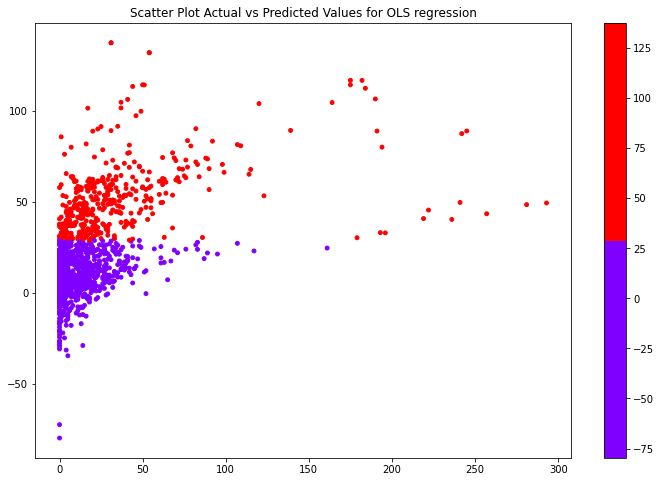

In [52]:
plt.figure(figsize = (12,8))
c_map = plt.cm.get_cmap('rainbow', 2)
plt.title('Scatter Plot Actual vs Predicted Values for OLS regression')
plt.scatter(test_y,y_pred_test, s = 15,
cmap = c_map , c = y_pred_test)
plt.colorbar()

##SVR regression and metrics

In [53]:
from sklearn.svm import SVR
#the parameters of kernel,c,gamma were selected by gridsearch

SVR_regression = SVR(kernel='rbf',C=20,gamma='scale')
SVR_regression.fit(train_x,train_y)

#Predicting a new result
y_pred_test_svr = SVR_regression.predict(test_x)
y_pred_train_svr = SVR_regression.predict(train_x)
y_pred_val_svr = SVR_regression.predict(validation_x)


In [54]:
# RMSE,spearman and pearson for test,train and validation data for SVR
print("RMSE for test data is : ", np.sqrt(metrics.mean_squared_error(test_y, y_pred_test_svr)))
print("RMSE for validation data is : ", np.sqrt(metrics.mean_squared_error(validation_y, y_pred_val_svr)))
print("RMSE for train data is : ", np.sqrt(metrics.mean_squared_error(train_y, y_pred_train_svr)))
print('\n')

#R-squared for all data 
print("R-squared for test data is : ", r2_score(test_y, y_pred_test_svr))
print("R-squared for validation data is : ", r2_score(validation_y, y_pred_val_svr))
print("R-squared for train data is : ", r2_score(train_y, y_pred_train_svr))
print('\n')

#Spearman correlations
print("Spearman correlation for test data is : ",spearmanr(test_y,y_pred_test_svr)[0])
print("Spearman correlation for validation data is : ",spearmanr(validation_y,y_pred_val_svr)[0])
print("Spearman correlation for train data is : ",spearmanr(train_y,y_pred_train_svr)[0])
print('\n')



#Pearson correlations 
print("Pearson correlation for test data is : ",pearsonr(test_y,y_pred_test_svr)[0])
print("Pearson correlation for validation data is : ",pearsonr(validation_y,y_pred_val_svr)[0])
print("Pearson correlation for train data is : ",pearsonr(train_y,y_pred_train_svr)[0])
print('\n')


RMSE for test data is :  24.569767188785264
RMSE for validation data is :  28.929900120134157
RMSE for train data is :  22.872767412835042


R-squared for test data is :  0.30859692177542075
R-squared for validation data is :  0.22895140658772595
R-squared for train data is :  0.36698079543786366


Spearman correlation for test data is :  0.6910132194223318
Spearman correlation for validation data is :  0.7357137528852419
Spearman correlation for train data is :  0.752378944751328


Pearson correlation for test data is :  0.563610727768854
Pearson correlation for validation data is :  0.5109332109191095
Pearson correlation for train data is :  0.6419811468309109




**The scatter plot of actual vs predicted values of the SVR model, displays a better scatter plot than the equivalent of OLS. This is apparent as less red points are visible which means that there are more overlapping values when compared to OLS**

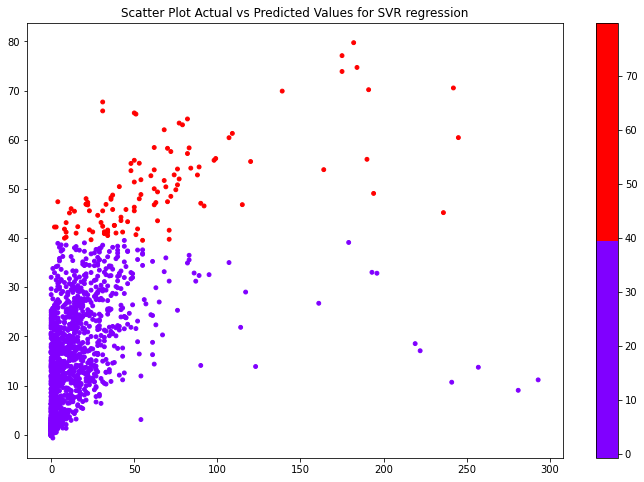

In [55]:
plt.figure(figsize = (12,8))
c_map = plt.cm.get_cmap('rainbow', 2)
plt.title('Scatter Plot Actual vs Predicted Values for SVR regression')
plt.scatter(test_y,y_pred_test_svr, s = 15,
cmap = c_map , c = y_pred_test_svr)
plt.colorbar()

## Task 3
The design followed was a basic CNN design with 4 layers. The image data was rescaled before fitting the model to 200x200 in order to preserve computational power.However someone must be very careful because valuable information could be lost when applying this technique. The image data rescaling was performed using keras rescaling and utilising a "bilinear interpolation". There was a change in regards to what folds were given to the data to train when compared to part 2 but this was made consiously to improve performance. Since data augmentation was not performed, instead of just training in the first fold, the model trained in folds 1 and 2 and tested on fold 3. The architecture equipped 4 layers with an expansion of neuros going from 32 to 256. The activation function selected was rectified linear unit. The model performed better than the OLS and SVR regressions but this could have been due to the nature of its training in more folds. However it is important to compare the different peprformances and metrics of the two different approaches when considering future applications of similar models.

In [56]:
#import deep learning libraries

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import PIL
import os
import os.path
from PIL import Image
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from collections import Counter
import pandas as pd
import tensorflow as tf
# importing layers from keras

from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, InputLayer, BatchNormalization, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, Flatten,MaxPooling2D

from sklearn.metrics import mean_squared_error,r2_score



In [57]:
#Resize dataset to reduce computational complexity, but be careful we cannot lose too much information

size = (200, 200)

X_scaled = tf.keras.preprocessing.image.smart_resize(
    X, size, interpolation='bilinear')

**I train the model on folds 1,2 of the scaled images and test on fold 3 (i call it validation data)**

In [58]:
#Merge 1st and 2nd fold of training and test on the third fold

train_scaled = X_scaled[Y.index.isin(np.where(F <= 2)[0])]
train_y_scaled = Y[Y.index.isin(np.where(F <= 2)[0])]['lymphocyte']


validation_x_scaled = X_scaled[Y.index.isin(np.where(F ==3)[0])]
validation_y_scaled = Y[Y.index.isin(np.where(F == 3)[0])]['lymphocyte']


In [59]:
#create CNN basic structure , add 3 layers and play around with parameters, this was the result when the loses seem to converge and the model somewhat learns
model = Sequential()
#3 layers expanding up to 128 neurons using relu activation function
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(200, 200 , 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200, 200 , 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(1))

optimizer = tf.optimizers.Adam(learning_rate=0.001)
#compile model using accuracy to measure model performance
model.compile(optimizer=optimizer, loss=['mean_absolute_error'], metrics=['mean_absolute_error'])
print(model.summary())

history = model.fit(train_scaled, train_y_scaled, validation_data=(validation_x_scaled, validation_y_scaled), epochs=50, batch_size = 128)
                    
#train the model
# history = model.fit(Xtrain_scaled, Ytrain, validation_data=(Xtrain_scaled, Ytrain), epochs=90, batch_size = 128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 64)        0

In [60]:
print(model.evaluate(train_scaled, 
                          train_y_scaled))

print(model.evaluate(validation_x_scaled, 
                          validation_y_scaled))

106/106 [==============================] - 1s 13ms/step - loss: 5.0285 - mean_absolute_error: 5.0285
[5.028478622436523, 5.028478622436523]
51/51 [==============================] - 1s 13ms/step - loss: 7.1500 - mean_absolute_error: 7.1500
[7.150035858154297, 7.150035858154297]


##MSE, RMSE,Correlations and Rsquared for the CNN model 

In [61]:
#dont be confused val is test iin this case cause of 1,2 fold used as training and 3rd named val as testing
val_y_pred = model.predict(validation_x_scaled)
print('Test dataset Metrics')
print('MSE:',mean_squared_error(validation_y_scaled, val_y_pred))
print('RMSE:',np.sqrt(mean_squared_error(validation_y_scaled, val_y_pred)))
print('Pearson:',pearsonr(validation_y_scaled, val_y_pred)[0])
print('Spearman:',spearmanr(validation_y_scaled, val_y_pred)[0])
print('Rsquared:',r2_score(validation_y_scaled, val_y_pred))

Test dataset Metrics
MSE: 209.98225222797342
RMSE: 14.490764376939314
Pearson: [0.8780642303749944]
Spearman: 0.8560456728288659
Rsquared: 0.7595018080926921


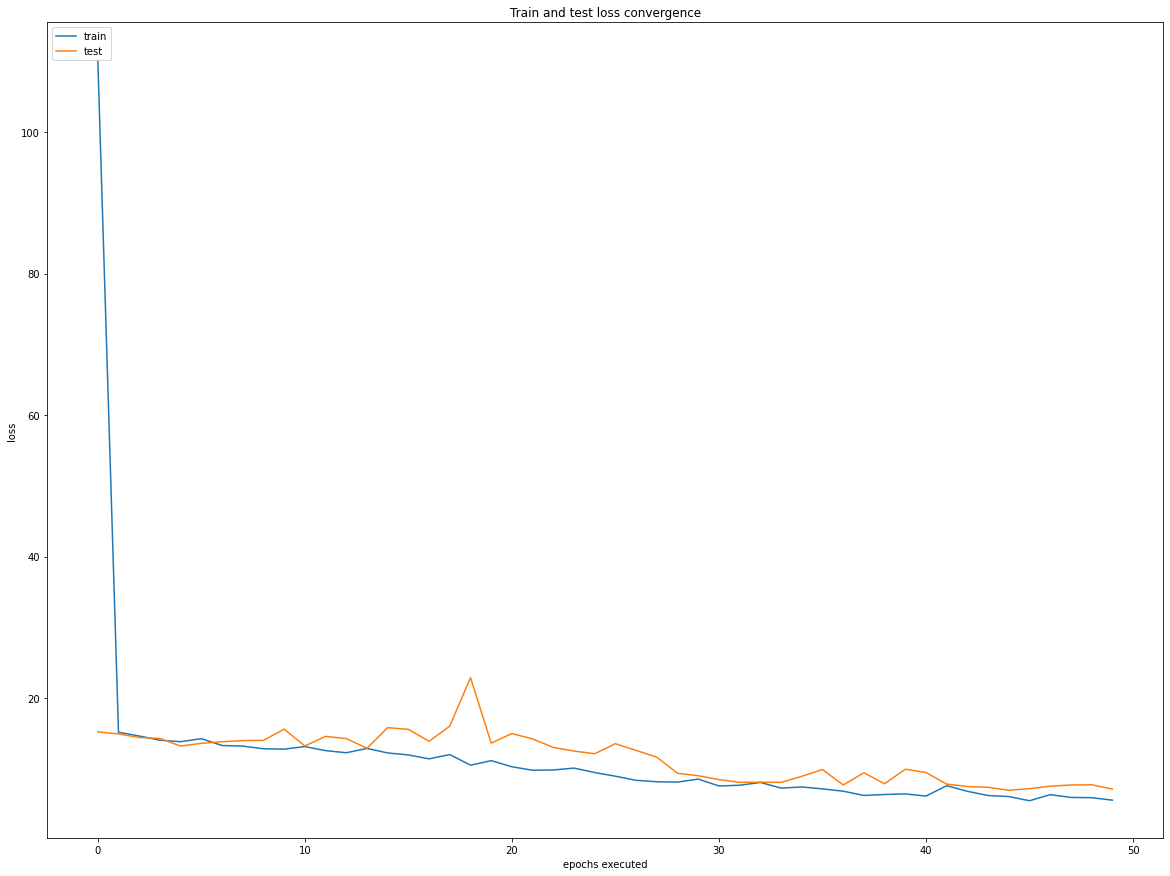

In [62]:
# summarize history for loss maybe early stopping would help here?
plt.plot(history.history['loss'])
#plt.show()
plt.plot(history.history['val_loss'])
plt.title('Train and test loss convergence')
plt.ylabel('loss')
plt.xlabel('epochs executed')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Scatter plot of true vs predicted label on test data of CNN architecture chosen

The scatter plot of the CNN provides the best result when compared to the scatter plots of the other 2 models. This can be observed by the reduced ammount of predicted vs actual values visible on the plot.

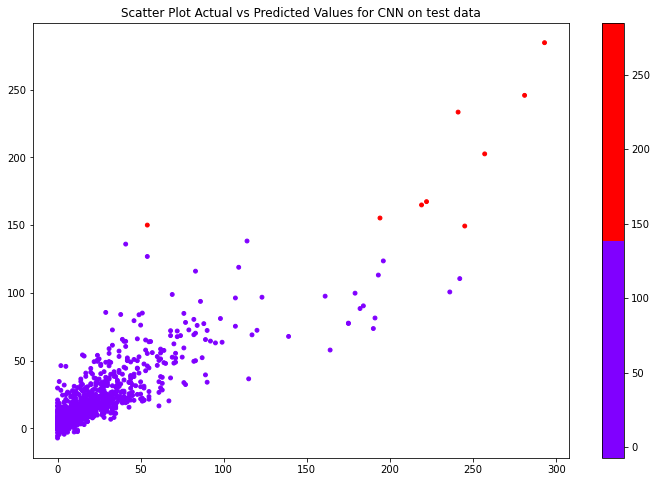

In [63]:
plt.figure(figsize = (12,8))
c_map_cnn = plt.cm.get_cmap('rainbow', 2)
plt.title('Scatter Plot Actual vs Predicted Values for CNN on test data')
plt.scatter(validation_y_scaled,val_y_pred, s = 15,
cmap = c_map , c = val_y_pred)
plt.colorbar()

## Task 3 ii) K-fold cross validation

In [73]:
# #this method will create indices for each fold so we can take combinations of the folds the following way : fold1,fold2 then fold2,3 and fold1,3

#due to computational complexity i was not able to run the 3 fold cross validation i have only done so for fold 1, GPU ram kept crushing also purchased colab pro for this and wasted 9£ i am so sorry but this was difficult


##Task 3.3 run CNN model to predict all 6 cell counts but i only did it for 1 fold

In [68]:
#Merge 1st and 2nd fold of training and test on the third fold

train_scaled_third = X_scaled[Y.index.isin(np.where(F <= 2)[0])]
train_y_scaled_third = Y[Y.index.isin(np.where(F <= 2)[0])]


validation_x_scaled_third = X_scaled[Y.index.isin(np.where(F ==3)[0])]
validation_y_scaled_third = Y[Y.index.isin(np.where(F == 3)[0])]

In [71]:
#create CNN basic structure , add 3 layers and play around with parameters, this was the result when the loses seem to converge and the model somewhat learns
model = Sequential()
#3 layers expanding up to 128 neurons using relu activation function
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(200, 200 , 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200, 200 , 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(6))

optimizer = tf.optimizers.Adam(learning_rate=0.001)
#compile model using accuracy to measure model performance
model.compile(optimizer=optimizer, loss=['mean_absolute_error'], metrics=['mean_absolute_error'])
print(model.summary())

history_third = model.fit(train_scaled_third, train_y_scaled_third, validation_data=(validation_x_scaled_third, validation_y_scaled_third), epochs=50, batch_size = 128)
                    
#train the model
# history = model.fit(Xtrain_scaled, Ytrain, validation_data=(Xtrain_scaled, Ytrain), epochs=90, batch_size = 128)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 99, 99, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 49, 49, 64)       

In [72]:
val_y_pred_third = model.predict(validation_x_scaled_third)
print('Validation dataset Metrics')
print('MSE:',mean_squared_error(validation_y_scaled_third, val_y_pred_third))
print('RMSE:',np.sqrt(mean_squared_error(validation_y_scaled_third, val_y_pred_third)))
# print('Pearson:',pearsonr(validation_y_scaled_third, val_y_pred_third))
# print('Spearman:',spearmanr(validation_y_scaled_third, val_y_pred_third)[0])
print('Rsquared:',r2_score(validation_y_scaled_third, val_y_pred_third))

Validation dataset Metrics
MSE: 164.58662483875457
RMSE: 12.829131881727406
Rsquared: 0.2999810379383229


We can observe a progression with the models applied in this CW when trying to predict T3 cells and modelling with different approaches. OLS displayed an **RMSE of 27.4** and **Rsquared of 0.14**. SVR performed better on test data and yielded metrics of ***RMSE of 24.5** and **Rsquared of 0.30** for the test data. Finally the CNN with the custom architecture that trained on greater volume of data displayed an **RMSE of 14.5** and an **Rsquared of 0.76**.

Performance for the cellular composition prediction of the 6 cells is worst than just for the T3 cells but this is justified.